WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [theta]


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\P
ython311\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 80 seconds.


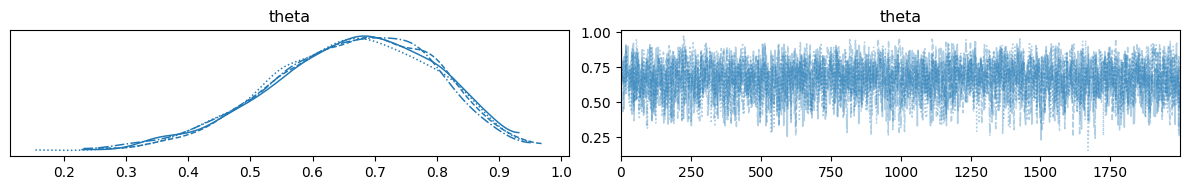

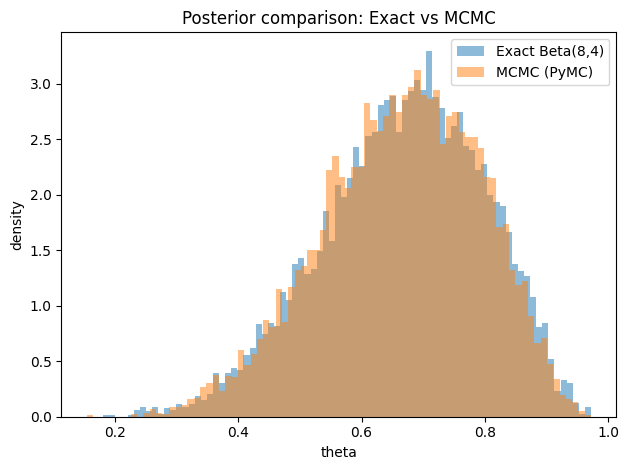

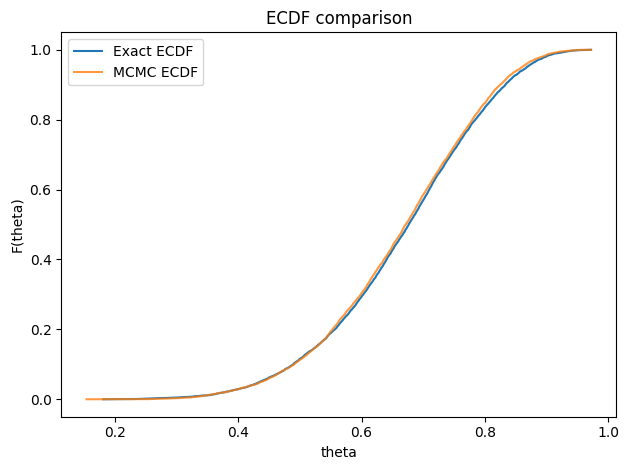


[Exact Beta(8,4)]
  mean   : 0.667138
  median : 0.676429
  94% HDI: [0.427560, 0.902802]
  95% CI : [0.389857, 0.892309]

[MCMC (PyMC)]
  mean   : 0.663342
  median : 0.671418
  94% HDI: [0.431827, 0.899920]
  95% CI : [0.390530, 0.884199]

[MCMC diagnostics]
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
theta  0.6633  0.1286  0.4318   0.8999     0.0024   0.0014  2803.7716   

       ess_tail   r_hat  
theta  3596.196  1.0004  

[Shape distance] approx KS = 0.017500


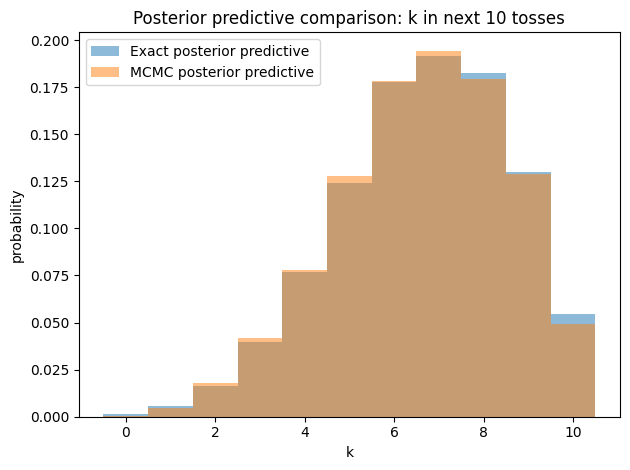

In [1]:
# pip install pymc arviz matplotlib numpy

import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ----------------------------
# データ：10回中7回表
# ----------------------------
n = 10
k = 7

# 事前 Beta(1,1)
a0, b0 = 1, 1

# 解析解の事後：Beta(a_post, b_post)
a_post = a0 + k
b_post = b0 + (n - k)

rng = np.random.default_rng(42)

# ----------------------------
# (A) MCMC (PyMC)
# ----------------------------
with pm.Model() as model:
    theta = pm.Beta("theta", alpha=a0, beta=b0)
    y = pm.Binomial("y", n=n, p=theta, observed=k)

    idata = pm.sample(
        draws=2000,
        tune=1000,
        chains=4,
        target_accept=0.9,
        random_seed=42
    )

theta_mcmc = idata.posterior["theta"].values.reshape(-1)  # (chains*draws,)

# ----------------------------
# (B) 解析解（共役）から直接サンプル
# ----------------------------
theta_exact = rng.beta(a_post, b_post, size=theta_mcmc.size)

# ----------------------------
# 比較①：トレース（MCMC側）
# ----------------------------
az.plot_trace(idata, var_names=["theta"])
plt.tight_layout()
plt.show()

# ----------------------------
# 比較②：事後分布の重ね描き（MCMC vs 解析解）
# ----------------------------
bins = 80
plt.hist(theta_exact, bins=bins, density=True, alpha=0.5, label=f"Exact Beta({a_post},{b_post})")
plt.hist(theta_mcmc,  bins=bins, density=True, alpha=0.5, label="MCMC (PyMC)")
plt.title("Posterior comparison: Exact vs MCMC")
plt.xlabel("theta")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 比較③：ECDF（累積分布）の比較（形の一致を見やすい）
# ----------------------------
def ecdf(x):
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / len(xs)
    return xs, ys

x1, y1 = ecdf(theta_exact)
x2, y2 = ecdf(theta_mcmc)

plt.plot(x1, y1, label="Exact ECDF")
plt.plot(x2, y2, label="MCMC ECDF", alpha=0.8)
plt.title("ECDF comparison")
plt.xlabel("theta")
plt.ylabel("F(theta)")
plt.legend()
plt.tight_layout()
plt.show()

# KS距離（最大の縦差）を自前で近似（SciPy不要）
grid = np.linspace(0, 1, 2001)
# ECDFをgrid上に近似
def ecdf_on_grid(sample, grid):
    s = np.sort(sample)
    # grid以下の個数 / N
    idx = np.searchsorted(s, grid, side="right")
    return idx / len(s)

F_exact = ecdf_on_grid(theta_exact, grid)
F_mcmc  = ecdf_on_grid(theta_mcmc,  grid)
ks = np.max(np.abs(F_exact - F_mcmc))

# ----------------------------
# 比較④：要約統計（平均・中央値・HDI）
# ----------------------------
def hdi_from_samples(x, hdi_prob=0.94):
    x = np.sort(x)
    m = int(np.floor(hdi_prob * len(x)))
    widths = x[m:] - x[:-m]
    i = np.argmin(widths)
    return float(x[i]), float(x[i + m])

def summarize(name, s):
    mean = float(np.mean(s))
    median = float(np.median(s))
    hdi94 = hdi_from_samples(s, 0.94)
    ci95  = (float(np.quantile(s, 0.025)), float(np.quantile(s, 0.975)))
    print(f"\n[{name}]")
    print(f"  mean   : {mean:.6f}")
    print(f"  median : {median:.6f}")
    print(f"  94% HDI: [{hdi94[0]:.6f}, {hdi94[1]:.6f}]")
    print(f"  95% CI : [{ci95[0]:.6f}, {ci95[1]:.6f}]")

summarize(f"Exact Beta({a_post},{b_post})", theta_exact)
summarize("MCMC (PyMC)", theta_mcmc)

# (MCMCの診断：R-hat/ESS)
print("\n[MCMC diagnostics]")
print(az.summary(idata, var_names=["theta"], round_to=4))

print(f"\n[Shape distance] approx KS = {ks:.6f}")

# ----------------------------
# 比較⑤：事後予測（次の10回の表の回数分布）
# ----------------------------
krep_exact = rng.binomial(n=10, p=theta_exact)
krep_mcmc  = rng.binomial(n=10, p=theta_mcmc)

bins_k = np.arange(-0.5, 10.6, 1)
plt.hist(krep_exact, bins=bins_k, density=True, alpha=0.5, label="Exact posterior predictive")
plt.hist(krep_mcmc,  bins=bins_k, density=True, alpha=0.5, label="MCMC posterior predictive")
plt.title("Posterior predictive comparison: k in next 10 tosses")
plt.xlabel("k")
plt.ylabel("probability")
plt.legend()
plt.tight_layout()
plt.show()
